# Substack User RFM Segmentation
Michael Gadhia

In [1]:
import numpy as np
import datetime as dt
import pytz
import pandas as pd
# Disable specific warning as DataFrame assignment causes false positive
pd.options.mode.chained_assignment = None
# Suppress FutureWarnings irrelevant to visualization section
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

## Data Cleaning
As far as I could tell, the best way to handle missing values for recency dates is to exclude them if enough values remain, as there isn't a clear way to fill them in with the information provided. Out of 51238 users, a total of 31167 have one of the two dates we can use for recency.

In [2]:
# DataFrame will be modified but can be regenerated from CSV
df_rfm = pd.read_csv('substack_users.csv')

In [3]:
# Remove users with no recency dates
df_rfm = df_rfm.dropna(subset=['last_email_open', 'last_clicked_at'], ignore_index=True, how='all')

In [4]:
# Parsing dates to datetime, all strings are ISO8601 format
df_rfm['last_email_open'] = pd.to_datetime(df_rfm['last_email_open'])
df_rfm['last_clicked_at'] = pd.to_datetime(df_rfm['last_clicked_at'])

In [5]:
# Date that records were extracted, 2025-07-18 at approximately 13:00 EDT (must be tz-aware as recency dates are in UTC)
# NOTE: This is here so more precision can be added if needed
check_date = dt.datetime(2025, 7, 18, 13)
etz = pytz.timezone('America/New_York')
check_date = etz.localize(check_date)

### Recency
There are two dates, one for the last email the user has opened and one for the last click. The most recent of these two dates will be used.

In [6]:
# Get the most recent interaction between last click and last email open
df_rfm['recency_date'] = df_rfm[['last_email_open', 'last_clicked_at']].max(axis=1)

# Calculate the recency by subtracting this from check_date
df_rfm['recency'] = check_date - df_rfm['recency_date']

# Convert this from a TimeDelta object to days (this can be changed)
df_rfm['recency'] = df_rfm['recency'].dt.days

### Frequency
Frequency will be judged by the `emails_opened_6mo` column. I suspect there may be something off about this metric based on the other columns but I would have to learn more about what the analytics measure and how accurately they are collected and labeled.

In [7]:
# Make properly named column for clearer use
df_rfm['frequency'] = df_rfm['emails_opened_6mo']

### Monetary
The revenue in dollars will be used for the monetary feature. It is important to note that only 41 out of 31167 users in the data set have nonzero revenue; this will be explored after the clustering is complete.

In [8]:
# Convert revenue from string to to float (could import and use Decimal but will normalize anyway)
df_rfm['monetary'] = pd.to_numeric(df_rfm['revenue'].str.strip('$'))

# Only 41 users with nonzero revenue in the data set
np.count_nonzero(df_rfm['monetary'])

41

## Clustering

In [9]:
# Normalize all three features
# Create a data set with all three features normalized
scaler = StandardScaler()
rfm = df_rfm[['recency', 'frequency', 'monetary']]
rfm_norm = pd.DataFrame(scaler.fit_transform(rfm))

In [10]:
# Test most accurate clustering by number of clusters (testing 3, 4, 5, and 6)
for n in range(3,7):
    kmeans = KMeans(n_clusters=n, max_iter=40, n_init='auto')
    kmeans.fit(rfm_norm)
    labels = kmeans.labels_
    sil_score = silhouette_score(rfm_norm, labels)
    print('Clusters:', n, 'Score:', sil_score)

Clusters: 3 Score: 0.6110077869334352
Clusters: 4 Score: 0.5782933764003053
Clusters: 5 Score: 0.5830223310967407
Clusters: 6 Score: 0.5546212221923481


While $n=3$ and $n=5$ clusters were tried, the former did not seem to separate data points well and the latter had the highest monetary user alone in a cluster, so 4 was chosen to continue the analysis.

In [11]:
# 4-cluster model
kmeans = KMeans(n_clusters=4, max_iter=100, n_init='auto')
kmeans.fit(rfm_norm)
km_labels = kmeans.labels_
sil_score = silhouette_score(rfm_norm, labels)

print('Score:', sil_score)

Score: 0.5546212221923481


In [12]:
# Encode the cluster in both the normalized and original DataFrame
# (The original contains the meaningful features)
rfm_norm['cluster'] = km_labels
rfm['cluster'] = km_labels

In [13]:
# Number of users in each cluster
rfm.value_counts('cluster')

cluster
3    19300
1     6736
0     5099
2       32
Name: count, dtype: int64

## Analysis and Results
Here is a 3D scatter plot of all the normalized data, colored by cluster. Below it is the same plot but with two axes scaled to 'zoomed in' removing some points but making the denser area more visible.

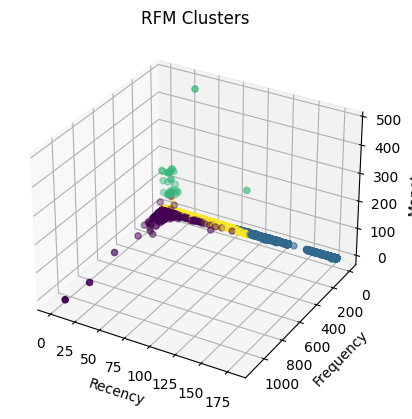

In [14]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(rfm['recency'], rfm['frequency'], rfm['monetary'], c=rfm['cluster'])
ax.invert_yaxis()
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('RFM Clusters')
plt.show()
fig.savefig('cluster_analysis.png')

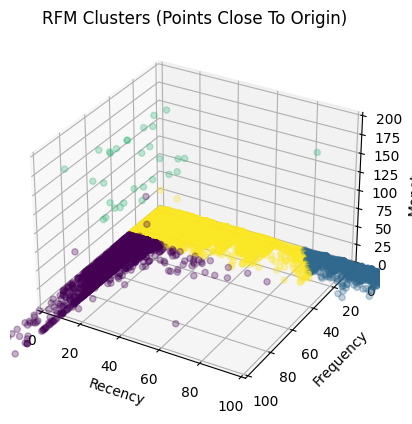

In [15]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(rfm['recency'], rfm['frequency'], rfm['monetary'], c=rfm['cluster'])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('RFM Clusters (Points Close To Origin)')

ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.set_zlim(0,200)

ax.invert_yaxis()
plt.show()

Here are plots of each pair of features against each other, giving each 2D slice of the above plot

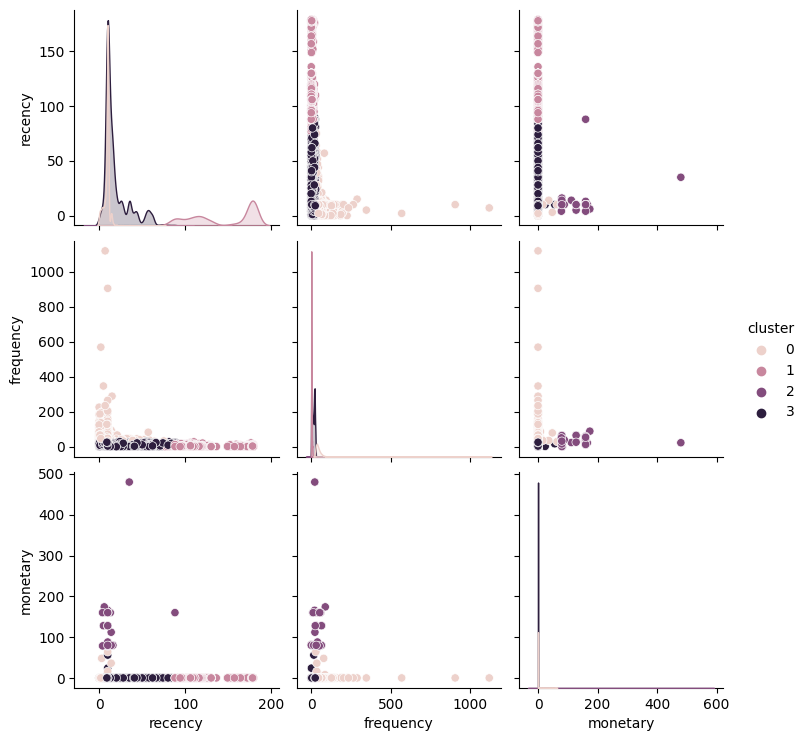

In [16]:
pairplot = sns.pairplot(data=rfm, hue='cluster')
plt.show(pairplot)
pairplot.savefig('2D_plots.png')

Using these plots and the number of users in each cluster shown above, we can see that the very few users with nonzero monetary value are mostly in their own small cluster. The other three clusters hold only a few users with nonzero revenue, but are separated by the other two features. One cluster contains users with low recency, and these users seem to have very low frequency as well.

The other two clusters contain more recent users, but the larger one (the largest of all clusters by a lot) has users who have clicked recently but not frequently, which may indicate that they have joined very recently, something that could be investigated further using their start date. The other cluster with more recent users, while smaller, contains more frequent users than the largest one. These could represent more active or current users, and all of the most frequent users are in this cluster, and these frequent users have all clicked somewhat recently (in fact, several nonzero revenue users are in this category).